In [8]:
# Setup

import numpy as np

# Ein Zufalls-Seed für Reproduzierbarkeit
np.random.seed(42)

from datetime import datetime
import random
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, utils

from IPython.display import display, clear_output

sns.set_theme()

print(f"GPUs für die Berechnung: {len(tf.config.experimental.list_physical_devices('GPU'))}")

GPUs für die Berechnung: 0


In [9]:
#Metadaten einlesen
df = pd.read_csv("NIHMS841832-supplement-1.csv", sep=',')
    
#Ergebnisse des Feature Tables einlesen
feature = pd.read_csv('feature_table.txt', sep='\t').T
feature = feature[1:][:-1]

feature

,0,1,2,3,4,5,6,7,8,9,...,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110
1629.SubjectIBD335,34292.0,20670.0,18413.0,9981.0,7071.0,6881.0,5411.0,5335.0,5289.0,4741.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD643,15243.0,64328.0,0.0,0.0,0.0,4.0,4507.0,3216.0,15630.0,199.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD539,22182.0,21589.0,0.0,1365.0,0.0,11501.0,33619.0,3638.0,5053.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD078,0.0,805.0,0.0,0.0,0.0,4.0,330.0,2305.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD671,0.0,19734.0,0.0,0.0,0.0,0.0,215.0,0.0,0.0,699.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629.SubjectIBD421,5154.0,12101.0,1572.0,62.0,190.0,1448.0,6316.0,2205.0,1885.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD202,14565.0,24920.0,3543.0,0.0,0.0,0.0,63.0,0.0,37768.0,48660.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD544,32.0,52.0,31.0,0.0,0.0,2.0,18543.0,0.0,3.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,946.0,31.0
1629.SubjectIBD422,5718.0,18420.0,9534.0,0.0,0.0,0.0,4791.0,2770.0,0.0,588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Gesunde Kontrollgruppe
HC = df[df.ibd_subtype.eq("HC")]

y = []
for row in feature.index:
    if any(True for val in HC['sample_name'] if val == row):
        y.append(1)
    else:
        y.append(0)

X = feature.iloc[:, :].values  
X

array([[34292.0, 20670.0, 18413.0, ..., 0.0, 0.0, 0.0],
       [15243.0, 64328.0, 0.0, ..., 0.0, 0.0, 0.0],
       [22182.0, 21589.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [32.0, 52.0, 31.0, ..., 0.0, 946.0, 31.0],
       [5718.0, 18420.0, 9534.0, ..., 0.0, 0.0, 0.0],
       [3151.0, 7071.0, 677.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [11]:
#Splitt nach Patient. Alle Zeitpunkte eines Patienten entweder in Train oder Test.
def split_function(tSize, random_state, table, metadata, hc_group):
    patientSamples = {}
    liste = []

    for row in metadata.index:
        liste.append(metadata['patientnumber'][row])

    menge = set(liste)  

    for e in menge:
        newPatient = metadata[metadata.patientnumber.eq(e)]
        patientSamples[e] = list(newPatient['sample_name'])

    shuffleListe = list(menge)
    random.Random(random_state).shuffle(shuffleListe)

    #Split. 137 PatientenNummern
    trainSize = int(np.round(tSize * 137, 0))
    testSize = 137 - trainSize

    X_trainEntry = shuffleListe[0:trainSize]
    X_testEntry = shuffleListe[trainSize:138]

    X_train = []
    y_train = []
    for i in X_trainEntry:
        try:
            value = patientSamples[i]
            for sample_name in value:
                for row in table.index:
                    if(row == sample_name):
                        temp = table.loc[[row]].values[0]
                        X_train.append(temp)
                        if any(True for val in hc_group['sample_name'] if val == row):
                            y_train.append(1)
                        else:
                            y_train.append(0)
        except KeyError as e:
            fehler += 1
            print('I got a KeyError - reason "%s"' % str(e))


    X_test = []   
    y_test = []
    for i in X_testEntry:
        try:
            value = patientSamples[i]
            for sample_name in value:
                for row in table.index:
                    if(row == sample_name):
                        temp = table.loc[[row]].values[0]
                        X_test.append(temp)
                        if any(True for val in hc_group['sample_name'] if val == row):
                            y_test.append(1)
                        else:
                            y_test.append(0)
        except KeyError as e:
            fehler += 1
            print('I got a KeyError - reason "%s"' % str(e))

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test

[[3.06290388e-03]
 [1.27974600e-01]
 [2.90274620e-05]
 [1.29484832e-02]
 [0.00000000e+00]
 [2.92956114e-01]
 [1.31815672e-04]
 [5.53196669e-03]
 [7.02100098e-02]
 [9.20066237e-02]
 [1.49071515e-01]
 [6.85682595e-02]
 [1.32886231e-01]
 [1.04333609e-01]
 [7.37625062e-02]
 [1.21936262e-01]
 [6.97198510e-02]
 [1.53590083e-01]
 [3.03969681e-02]
 [3.75979245e-02]
 [5.69522679e-02]
 [4.43333387e-03]
 [1.77901894e-01]
 [2.78279781e-02]
 [6.97327554e-02]
 [3.57605517e-02]
 [4.12791371e-02]
 [0.00000000e+00]
 [3.64581347e-02]
 [5.21704555e-03]
 [5.39266765e-02]
 [1.04466081e-03]
 [0.00000000e+00]
 [2.07398534e-02]
 [0.00000000e+00]
 [2.08169222e-04]
 [6.91247284e-02]
 [8.91685486e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.11016631e-02]
 [2.73365855e-01]
 [1.91521883e-01]
 [3.10303271e-02]
 [2.13831663e-04]
 [1.73541903e-03]
 [1.13248825e-04]
 [6.97322786e-02]
 [1.74939632e-05]
 [4.39377725e-02]
 [0.00000000e+00]
 [6.145089

/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

<AxesSubplot:>

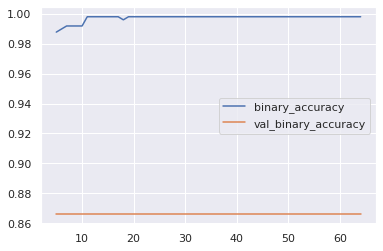

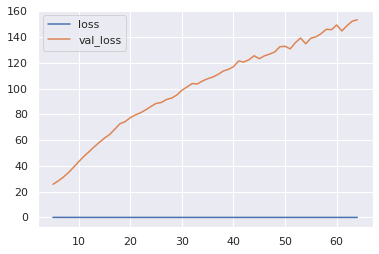

In [15]:
#def nn():
#Split Test und Trainingsdaten
X_train, X_test, y_train, y_test = split_function(tSize=0.7, random_state=0, table=feature, metadata=df, hc_group=HC)
trainSize = len(X_train)/681
testSize =len(X_test)/681


#Featuer Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Das Modell soll aufhören zu rechnen, falls es keine nennenswerten Verbesserungen mehr gibt
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=64,
    restore_best_weights=True
)

# Das NN besteht aus einer Mischung von Dense-, Normalization- und Dropout-Layern.
# Dropout führt allem Anschein nach zu schlechterem F1
# Weniger LUs führen zu besseren Ergebnissen
network = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    #layers.Dropout(rate=0.5),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(rate=0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

# NN kompilieren
network.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy()]
)

# NN trainieren
history = network.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=512,
    callbacks=[early_stopping],
    verbose=0
)

# Scores berechnen
history_df = pd.DataFrame(history.history)

y_pred = network.predict(X_test)
print(y_pred)
y_pred_corrected = []
    
for pred in y_pred:
    if pred > 0.7:
        y_pred_corrected.append(1)
    else: 
        y_pred_corrected.append(0)

report = sklearn.metrics.classification_report(y_test, y_pred_corrected)
f1 = f1_score(y_test, y_pred_corrected, average='macro')
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_corrected)
print(confusion_matrix)
print(report)
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()
history_df.loc[5:, ['loss', 'val_loss']].plot()

#return f1, report, network

In [13]:
#nn()